In [3]:

import sys
sys.path.insert(1, '../')

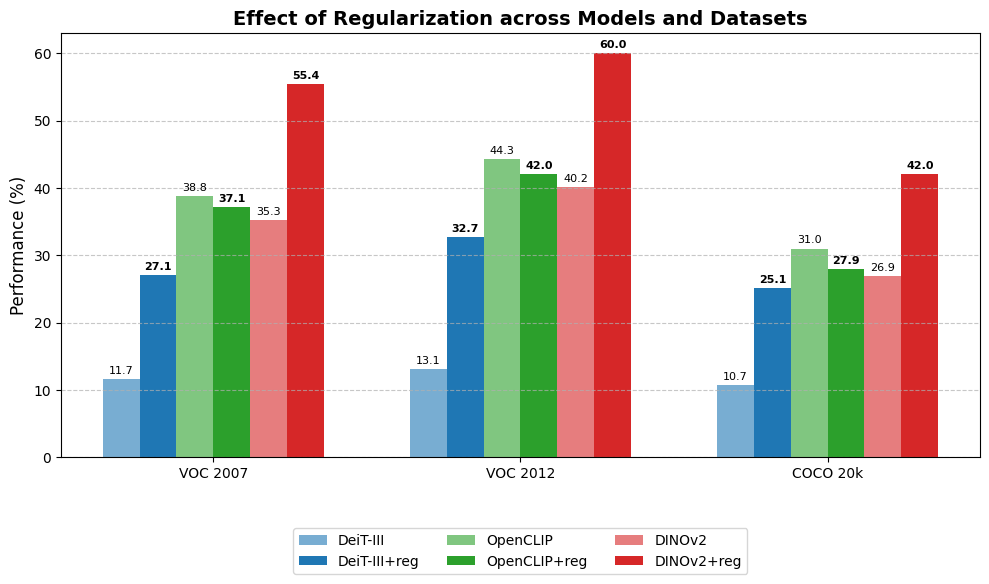

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Datasets
datasets = ["VOC 2007", "VOC 2012", "COCO 20k"]

# Values
deit = [11.7, 13.1, 10.7]
deit_reg = [27.1, 32.7, 25.1]
openclip = [38.8, 44.3, 31.0]
openclip_reg = [37.1, 42.0, 27.9]
dinov2 = [35.3, 40.2, 26.9]
dinov2_reg = [55.4, 60.0, 42.0]

models = {
    "DeiT-III": (deit, deit_reg),
    "OpenCLIP": (openclip, openclip_reg),
    "DINOv2": (dinov2, dinov2_reg)
}

x = np.arange(len(datasets))
width = 0.12

fig, ax = plt.subplots(figsize=(10, 6))

# Offset each model group
offsets = [-2*width, 0, 2*width]
colors = ["#1f77b4", "#2ca02c", "#d62728"]

for (model, (base, reg)), offset, color in zip(models.items(), offsets, colors):
    ax.bar(x + offset - width/2, base, width, label=f"{model}", color=color, alpha=0.6)
    ax.bar(x + offset + width/2, reg, width, label=f"{model}+reg", color=color)

# Labels and title
ax.set_ylabel("Performance (%)", fontsize=12)
ax.set_title("Effect of Regularization across Models and Datasets", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend(ncol=3, bbox_to_anchor=(0.5, -0.15), loc='upper center')

# Grid and annotations
ax.grid(axis='y', linestyle='--', alpha=0.7)

for i, (model, (base, reg)) in enumerate(models.items()):
    for j, (b, r) in enumerate(zip(base, reg)):
        ax.text(x[j] + offsets[i] - width/2, b + 0.8, f'{b:.1f}', ha='center', fontsize=8)
        ax.text(x[j] + offsets[i] + width/2, r + 0.8, f'{r:.1f}', ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()



In [4]:
sys.path

['/home/cboned/Projects/Koopman-Learning/notebooks',
 '../',
 '/home/cboned/miniconda3/envs/graphocr/lib/python310.zip',
 '/home/cboned/miniconda3/envs/graphocr/lib/python3.10',
 '/home/cboned/miniconda3/envs/graphocr/lib/python3.10/lib-dynload',
 '',
 '/home/cboned/miniconda3/envs/graphocr/lib/python3.10/site-packages']

In [9]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"


import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


from collections import defaultdict
import tqdm
from datasets import Collator

from torch_pca import PCA
import os

from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader

from transformers import ViTForImageClassification , ViTImageProcessor, AutoImageProcessor, ViTModel
from models.ode_transformer_gpt  import ViTNeuralODE
from model_backup import ViTNeuralODE as VITNODEBackup
import numpy as np
import scienceplots

from torchdiffeq import odeint
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.manifold import TSNE


cuda


In [10]:
def plot_trajectories_comparison(teacher_trajectories, student_trajectories, 
                               reduction_method='pca', figsize=(15, 10)):
    """
    Plot trajectories from teacher and student models in the same plot.
    
    Args:
        teacher_trajectories: torch.Tensor of shape [B, T1, D] - teacher model trajectories
        student_trajectories: torch.Tensor of shape [B, T2, D] - student model trajectories  
        reduction_method: str - 'pca' or 'tsne' for dimensionality reduction
        figsize: tuple - figure size
    """
    # Convert to numpy
    teacher_traj = teacher_trajectories.detach().cpu().numpy()
    student_traj = student_trajectories.detach().cpu().numpy()
    
    B, T1, D = teacher_traj.shape
    _, T2, _ = student_traj.shape
    
    # Reshape for dimensionality reduction: [B*T1 + B*T2, D]
    teacher_flat = teacher_traj.reshape(-1, D)
    student_flat = student_traj.reshape(-1, D)
    all_points = np.concatenate([teacher_flat, student_flat], axis=0)
    
    # Apply dimensionality reduction
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_points = reducer.fit_transform(all_points)
        title_suffix = f"PCA (explained variance: {reducer.explained_variance_ratio_.sum():.2f})"
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_points)//4))
        reduced_points = reducer.fit_transform(all_points)
        title_suffix = "t-SNE"
    
    # Split back into teacher and student
    teacher_2d = reduced_points[:B*T1].reshape(B, T1, 2)
    student_2d = reduced_points[B*T1:].reshape(B, T2, 2)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color palette for different samples
    colors = plt.cm.Set3(np.linspace(0, 1, B))
    
    # Plot trajectories
    for i in range(B):
        # Teacher trajectory (solid line)
        ax.plot(teacher_2d[i, :, 0], teacher_2d[i, :, 1], 
                color=colors[i], linewidth=2.5, alpha=0.8, 
                linestyle='-', label=f'Teacher Sample {i+1}' if i < 5 else "")
        
        # Student trajectory (dashed line, same color)
        ax.plot(student_2d[i, :, 0], student_2d[i, :, 1], 
                color=colors[i], linewidth=2.5, alpha=0.8, 
                linestyle='--', label=f'Student Sample {i+1}' if i < 5 else "")
        
        # Mark start points (circles)
        ax.scatter(teacher_2d[i, 0, 0], teacher_2d[i, 0, 1], 
                  color=colors[i], s=80, marker='o', edgecolor='black', 
                  linewidth=1.5, alpha=0.9)
        ax.scatter(student_2d[i, 0, 0], student_2d[i, 0, 1], 
                  color=colors[i], s=80, marker='s', edgecolor='black', 
                  linewidth=1.5, alpha=0.9)
        
        # Mark end points (stars)
        ax.scatter(teacher_2d[i, -1, 0], teacher_2d[i, -1, 1], 
                  color=colors[i], s=120, marker='*', edgecolor='black', 
                  linewidth=1.5, alpha=0.9)
        ax.scatter(student_2d[i, -1, 0], student_2d[i, -1, 1], 
                  color=colors[i], s=120, marker='P', edgecolor='black', 
                  linewidth=1.5, alpha=0.9)
    
    # Create custom legend
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=2, linestyle='-', label='Teacher Trajectory'),
        Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Student Trajectory'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=8, label='Start (Teacher)', markeredgecolor='black'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
               markersize=8, label='Start (Student)', markeredgecolor='black'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', 
               markersize=10, label='End (Teacher)', markeredgecolor='black'),
        Line2D([0], [0], marker='P', color='w', markerfacecolor='gray', 
               markersize=10, label='End (Student)', markeredgecolor='black')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
              fancybox=True, shadow=True)
    
    ax.set_title(f'Teacher vs Student Model Trajectories Comparison\n({title_suffix}) - T_teacher={T1}, T_student={T2}', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Component 1', fontsize=12, fontweight='bold')
    ax.set_ylabel('Component 2', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    return fig



def plot_final_states_scatter(teacher_trajectories, student_trajectories, 
                            acc_t, acc_edo, agreement, reduction_method='pca', 
                            figsize=(12, 10)):
    """
    Scatter plot of final hidden states with distance lines and classification indicators.
    
    Args:
        teacher_trajectories: torch.Tensor - teacher trajectories [B, T1, D]
        student_trajectories: torch.Tensor - student trajectories [B, T2, D]
        acc_t: list - teacher model accuracy for each sample
        acc_edo: list - student model accuracy for each sample
        agreement: list - agreement between models for each sample
        reduction_method: str - 'pca' or 'tsne'
        figsize: tuple - figure size
    """
    # Get final states (last time step)
    teacher_final = teacher_trajectories[:, -1, :].detach().cpu().numpy()
    student_final = student_trajectories[:, -1, :].detach().cpu().numpy()
    
    # Combine for dimensionality reduction
    all_final_states = np.concatenate([teacher_final, student_final], axis=0)
    
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_states = reducer.fit_transform(all_final_states)
        title_suffix = f"PCA (explained variance: {reducer.explained_variance_ratio_.sum():.2f})"
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_final_states)//4))
        reduced_states = reducer.fit_transform(all_final_states)
        title_suffix = "t-SNE"
    
    # Split back
    B = len(teacher_final)
    teacher_final_2d = reduced_states[:B]
    student_final_2d = reduced_states[B:]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine colors and markers based on accuracy and agreement
    for i in range(B):
        # Determine color based on classification correctness
        both_correct = acc_t[i] == 1 and acc_edo[i] == 1
        both_wrong = acc_t[i] == 0 and acc_edo[i] == 0
        disagreement = acc_t[i] != acc_edo[i]
        
        if both_correct:
            color = 'green'
        elif both_wrong:
            color = 'red'
        else:  # disagreement
            color = 'orange'
        
        # Determine marker based on agreement
        if agreement[i] == 1:
            teacher_marker = 'o'
            student_marker = 'o'
        else:
            teacher_marker = '^'
            student_marker = 's'
        
        # Plot teacher point
        ax.scatter(teacher_final_2d[i, 0], teacher_final_2d[i, 1], 
                  color=color, s=120, marker=teacher_marker, 
                  edgecolor='black', linewidth=2, alpha=0.8,
                  label='Teacher' if i == 0 else "")
        
        # Plot student point  
        ax.scatter(student_final_2d[i, 0], student_final_2d[i, 1], 
                  color=color, s=120, marker=student_marker, 
                  edgecolor='white', linewidth=2, alpha=0.8,
                  label='Student' if i == 0 else "")
        
        # Draw line between corresponding points
        ax.plot([teacher_final_2d[i, 0], student_final_2d[i, 0]], 
                [teacher_final_2d[i, 1], student_final_2d[i, 1]], 
                color=color, alpha=0.6, linewidth=1.5, linestyle=':')
        
        # Add sample number annotation
        mid_x = (teacher_final_2d[i, 0] + student_final_2d[i, 0]) / 2
        mid_y = (teacher_final_2d[i, 1] + student_final_2d[i, 1]) / 2
        ax.annotate(f'{i+1}', (mid_x, mid_y), fontsize=9, ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Create comprehensive legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
               markersize=10, label='Both Correct', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Both Wrong', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
               markersize=10, label='Disagreement', markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=10, label='Agreement (same marker)', markeredgecolor='black'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', 
               markersize=10, label='No Agreement (diff markers)', markeredgecolor='black'),
        Line2D([0], [0], color='gray', linewidth=2, linestyle=':', label='Distance Line')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
              fancybox=True, shadow=True)
    
    ax.set_title(f'Final Hidden States Comparison\n({title_suffix})', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Component 1', fontsize=12, fontweight='bold')
    ax.set_ylabel('Component 2', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    return fig


def plot_distance_distributions(teacher_trajectories, student_trajectories, 
                               acc_t, acc_edo, agreement, figsize=(15, 5)):
    """
    Plot distributions of distances between final teacher and student states.
    
    Args:
        teacher_trajectories: torch.Tensor - teacher trajectories [B, T1, D]
        student_trajectories: torch.Tensor - student trajectories [B, T2, D]
        acc_t: list - teacher model accuracy
        acc_edo: list - student model accuracy  
        agreement: list - agreement between models
        figsize: tuple - figure size
    """
    # Calculate distances between final states
    teacher_final = teacher_trajectories[:, -1, :].detach().cpu()
    student_final = student_trajectories[:, -1, :].detach().cpu()
    
    distances = torch.norm(teacher_final - student_final, dim=1).numpy()
    
    # Categorize distances
    both_correct_distances = []
    both_wrong_distances = []
    disagreement_distances = []
    agreement_distances = []
    no_agreement_distances = []
    
    for i in range(len(distances)):
        dist = distances[i]
        
        # Classification-based categorization
        if acc_t[i] == 1 and acc_edo[i] == 1:
            both_correct_distances.append(dist)
        elif acc_t[i] == 0 and acc_edo[i] == 0:
            both_wrong_distances.append(dist)
        else:
            disagreement_distances.append(dist)
        
        # Agreement-based categorization
        if agreement[i] == 1:
            agreement_distances.append(dist)
        else:
            no_agreement_distances.append(dist)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Distribution by classification correctness
    ax1.hist([both_correct_distances, both_wrong_distances, disagreement_distances], 
             bins=15, alpha=0.7, label=['Both Correct', 'Both Wrong', 'Disagreement'],
             color=['green', 'red', 'orange'], density=True, edgecolor='black')
    
    ax1.set_title('Distance Distribution by Classification', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Distance between Final States', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax1.legend(frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor('#f8f9fa')
    
    # Add statistics text
    stats_text = f'Both Correct: μ={np.mean(both_correct_distances):.3f}, σ={np.std(both_correct_distances):.3f}\n'
    stats_text += f'Both Wrong: μ={np.mean(both_wrong_distances):.3f}, σ={np.std(both_wrong_distances):.3f}\n'
    stats_text += f'Disagreement: μ={np.mean(disagreement_distances):.3f}, σ={np.std(disagreement_distances):.3f}'
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Distribution by agreement
    ax2.hist([agreement_distances, no_agreement_distances], 
             bins=15, alpha=0.7, label=['Agreement', 'No Agreement'],
             color=['blue', 'purple'], density=True, edgecolor='black')
    
    ax2.set_title('Distance Distribution by Model Agreement', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Distance between Final States', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax2.legend(frameon=True, fancybox=True, shadow=True)
    ax2.grid(True, alpha=0.3)
    ax2.set_facecolor('#f8f9fa')
    
    # Add statistics text
    stats_text2 = f'Agreement: μ={np.mean(agreement_distances):.3f}, σ={np.std(agreement_distances):.3f}\n'
    stats_text2 += f'No Agreement: μ={np.mean(no_agreement_distances):.3f}, σ={np.std(no_agreement_distances):.3f}'
    ax2.text(0.02, 0.98, stats_text2, transform=ax2.transAxes, fontsize=9,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

def plot_student_trajectories(
    student_trajectories,
    labels,
    class_name,
    reduction_method='pca',
    figsize=(15, 10)
):
    """
    Plot trajectories from student model and show class colors in an external legend.
    
    Args:
        student_trajectories: torch.Tensor of shape [B, T2, D]
        labels: list or np.ndarray of shape [B] with class indices
        class_name: dict mapping {int: str}
        reduction_method: 'pca' or 'tsne'
        figsize: figure size
    """
    # Convert to numpy
    student_traj = student_trajectories.detach().cpu().numpy()
    B, T2, D = student_traj.shape

    # Flatten for dimensionality reduction
    student_flat = student_traj.reshape(-1, D)
    all_points = student_flat

    # Dimensionality reduction
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_points = reducer.fit_transform(all_points)
        title_suffix = f"PCA (explained variance: {reducer.explained_variance_ratio_.sum():.2f})"
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_points)//4))
        reduced_points = reducer.fit_transform(all_points)
        title_suffix = "t-SNE"
    else:
        raise ValueError("reduction_method must be 'pca' or 'tsne'")

    # Back to [B, T2, 2]
    student_2d = reduced_points.reshape(B, T2, 2)

    # Plot setup
    fig, ax = plt.subplots(figsize=figsize)
    colors =[plt.cm.tab20(i) for i in range(len(class_name))]  # color per class

    # Plot trajectories
    for i in range(B):
        color = colors[labels[i]]
        ax.plot(student_2d[i, :, 0], student_2d[i, :, 1],
                color=color, linewidth=2.5, alpha=0.8,
                linestyle='--')
        ax.scatter(student_2d[i, 0, 0], student_2d[i, 0, 1],
                   color=color, s=80, marker='s', edgecolor='black',
                   linewidth=1.5, alpha=0.9)
        ax.scatter(student_2d[i, -1, 0], student_2d[i, -1, 1],
                   color=color, s=120, marker='P', edgecolor='black',
                   linewidth=1.5, alpha=0.9)

    # --- Custom legends ---
    # (1) Legend for trajectory meaning
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=2, linestyle='--', label='Student Trajectory'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray',
               markersize=8, label='Start', markeredgecolor='black'),
        Line2D([0], [0], marker='P', color='w', markerfacecolor='gray',
               markersize=10, label='End', markeredgecolor='black')
    ]
    ax.legend(handles=legend_elements, loc='upper left', frameon=True,
              fancybox=True, shadow=True)

    # (2) Legend for class colors (outside plot)
    class_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=colors[i], label=class_name[i],
               markersize=10, markeredgecolor='black')
        for i in range(len(class_name))
    ]
    ax.legend(handles=class_elements, loc='center left', bbox_to_anchor=(1.05, 0.5),
              title='Classes', frameon=True, fancybox=True, shadow=False)

    ax.set_title(f'Student Model Trajectories ({title_suffix})\nT_student={T2}',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Component 1', fontsize=12, fontweight='bold')
    ax.set_ylabel('Component 2', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#f8f9fa')

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for external legend
    return fig

In [11]:
# Set Matplotlib style
plt.style.use("science")
plt.rcParams['text.usetex'] = False

plt.rcParams.update(
    {
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 13,
        "legend.fontsize": 11,
        "figure.dpi": 300,
    }
)


In [20]:
EDO_CHECKPOINT_PATH = "/data/users/cboned/checkpoints/EDO_DISTILLATION_VITDINO_ON_CIFAR10_ATTENTION_DISTILL_FULL_PATH_MSE_PE_REGISTERS.pt"
DATASET_PATH = "/data/users/cboned/cifar"

In [21]:
train_dataset = CIFAR10(root=DATASET_PATH, download=False, train=True)
validation_dataset = CIFAR10(root=DATASET_PATH, download=False, train=False)


In [22]:
class_name_cif100  = {
    0: 'beaver',
    1: 'dolphin',
    2: 'otter',
    3: 'seal',
    4: 'whale',
    5: 'aquarium fish',
    6: 'flatfish',
    7: 'ray',
    8: 'shark',
    9: 'trout',
    10: 'orchids',
    11: 'poppies',
    12: 'roses',
    13: 'sunflowers',
    14: 'tulips',
    15: 'bottles',
    16: 'bowls',
    17: 'cans',
    18: 'cups',
    19: 'plates',
    20: 'apples',
    21: 'mushrooms',
    22: 'oranges',
    23: 'pears',
    24: 'sweet peppers',
    25: 'clock',
    26: 'computer keyboard',
    27: 'lamp',
    28: 'telephone',
    29: 'television',
    30: 'bed',
    31: 'chair',
    32: 'couch',
    33: 'table',
    34: 'wardrobe',
    35: 'bee',
    36: 'beetle',
    37: 'butterfly',
    38: 'caterpillar',
    39: 'cockroach',
    40: 'bear',
    41: 'leopard',
    42: 'lion',
    43: 'tiger',
    44: 'wolf',
    45: 'bridge',
    46: 'castle',
    47: 'house',
    48: 'road',
    49: 'skyscraper',
    50: 'cloud',
    51: 'forest',
    52: 'mountain',
    53: 'plain',
    54: 'sea',
    55: 'camel',
    56: 'cattle',
    57: 'chimpanzee',
    58: 'elephant',
    59: 'kangaroo',
    60: 'fox',
    61: 'porcupine',
    62: 'possum',
    63: 'raccoon',
    64: 'skunk',
    65: 'crab',
    66: 'lobster',
    67: 'snail',
    68: 'spider',
    69: 'worm',
    70: 'baby',
    71: 'boy',
    72: 'girl',
    73: 'man',
    74: 'woman',
    75: 'crocodile',
    76: 'dinosaur',
    77: 'lizard',
    78: 'snake',
    79: 'turtle',
    80: 'hamster',
    81: 'mouse',
    82: 'rabbit',
    83: 'shrew',
    84: 'squirrel',
    85: 'maple',
    86: 'oak',
    87: 'palm',
    88: 'pine',
    89: 'willow',
    90: 'bicycle',
    91: 'bus',
    92: 'motorcycle',
    93: 'pickup truck',
    94: 'train',
    95: 'lawn-mower',
    96: 'rocket',
    97: 'streetcar',
    98: 'tank',
    99: 'tractor'
}



class_name_cif10 = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}


In [23]:

processor = AutoImageProcessor.from_pretrained("facebook/dino-vitb16", use_fast=False)
collator = Collator(processor)
train_dloader = DataLoader(train_dataset, 
                           shuffle=False,
                           batch_size=1,
                           pin_memory=False,
                           num_workers=1,
                           collate_fn=collator.classification_collate_fn
                           )


test_dloader = DataLoader(validation_dataset,
                          batch_size=256,
                          pin_memory=False,
                          num_workers=1,
                          drop_last=True,
                          shuffle=False,
                          collate_fn=collator.classification_collate_fn

)

In [24]:
teacher_model_checkpoint = "../checkpoints/Vit_CIFAR10_DINO.pt" #
teacher_model = ViTForImageClassification.from_pretrained(teacher_model_checkpoint, attn_implementation='eager').to(device)
#teacher_model = ViTModel.from_pretrained("facebook/dino-vitb16").to(device)
#teacher_model = teacher_model.eval()


In [25]:
weights = torch.load(EDO_CHECKPOINT_PATH, weights_only=True)


In [26]:
weights["state_dict"].keys()

odict_keys(['patch_embed.cls_token', 'patch_embed.register_tokens', 'patch_embed.pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'odefunc.block.norm_attn.weight', 'odefunc.block.norm_attn.bias', 'odefunc.block.norm_mlp.weight', 'odefunc.block.norm_mlp.bias', 'odefunc.block.attn.mha.in_proj_weight', 'odefunc.block.attn.mha.out_proj.weight', 'odefunc.block.mlp.fc1.weight', 'odefunc.block.mlp.fc2.weight', 'head.weight', 'head.bias'])

In [29]:
model = ViTNeuralODE(
    img_size=224,
    patch_size=16,
    in_chans=3,
    mlp_ratio=4,
    num_classes=10,
    embed_dim=768,
    num_heads=12,
    emulate_depth=12.0,
    time_interval=1.0,   # match 12 "layers" by integrating over [0,12]
    num_eval_steps=24,
    solver="euler",
    register_tokens=10,
    pos_embed_register_tokens=True
)

#model.

try:
    model.load_state_dict(torch.load(EDO_CHECKPOINT_PATH, weights_only=True)["state_dict"])
except Exception as e:
    print(e)
    print("Matching individual Weights")
    weight_to_update = torch.load(EDO_CHECKPOINT_PATH, weights_only=True)
    for w in weight_to_update.keys():
        if model.state_dict().get(w) is not None:
            model.state_dict()[w].data.copy_(weight_to_update[w])

                
model = model.to(device)
model = model.eval()

In [30]:
print(next(iter(train_dloader))["labels"])

tensor([6])


## Extracting Prototypes

In [31]:
train_dloader = DataLoader(train_dataset, 
                           shuffle=False,
                           batch_size=256,
                           pin_memory=False,
                           num_workers=1,
                           collate_fn=collator.classification_collate_fn
                           )

In [32]:
# Dictionary to store prototype representations per class
prototypes = {}
feats_teacher=[]
all_labels = []

for batch_idx, data in tqdm.tqdm(
    enumerate(test_dloader),
    desc="Extracting Teacher Prototypes",
    total=len(test_dloader),
):
    inputs: dict = data["pixel_values"].to(device)
    labels: torch.Tensor = data["labels"].to(device)

    with torch.no_grad():
        # Forward pass through teacher model
        output_teacher = teacher_model(**inputs, output_hidden_states=True)
        hidden_states = torch.stack(output_teacher.hidden_states, dim=0)[1:]

        # Get the last hidden state: shape [batch_size, seq_len, hidden_dim]
        last_hidden = output_teacher.hidden_states[-1]  # shape: [B, S, D]

        # Assuming CLS token is at position 0
        cls_tokens = last_hidden[:, 0, :]  # shape: [B, D]
        feats_teacher.append(hidden_states[:,:,0].cpu().numpy())
        all_labels.extend(labels.cpu().numpy().tolist())

        # Aggregate prototypes per class
        for label, cls_feat in zip(labels.cpu().numpy(), cls_tokens.cpu()):
            if label not in prototypes:
                prototypes[label] = []
            prototypes[label].append(cls_feat)

# Convert lists to mean prototype per class
for label in prototypes:
    prototypes[label] = torch.stack(prototypes[label], dim=0).mean(0)

#print("Extracted class prototypes:", prototypes)

Extracting Teacher Prototypes: 100%|██████████| 39/39 [00:37<00:00,  1.04it/s]


In [33]:
prototypes[0].shape

torch.Size([768])

In [34]:
train_dloader = DataLoader(train_dataset, 
                           shuffle=False,
                           batch_size=100,
                           pin_memory=False,
                           num_workers=1,
                           collate_fn=collator.classification_collate_fn
                           )


test_dloader = DataLoader(validation_dataset,
                          batch_size=1,
                          pin_memory=False,
                          num_workers=1,
                          drop_last=True,
                          shuffle=True,
                          collate_fn=collator.classification_collate_fn

)

In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np


results_by_eval_steps = []
#for num_eval_steps in [240]:
    
feats = []
feats_teacher = []
acc_edo = []
# store preds and gts
all_labels = []
all_preds_edo = []
mse_s = []
#t_grid = torch.linspace(0.0, 1, num_eval_steps)

for batch_idx, data in tqdm.tqdm(
    enumerate(test_dloader),
    desc="Evaluating EDO",
    total=len(test_dloader),
):
    inputs: dict = data["pixel_values"].to(device)
    labels: torch.Tensor = data["labels"].to(device)
    #print("LABELS", labels.item())
    with torch.no_grad():
        # --- student/edo ---
        output_edo = model(**inputs, labels=labels, output_hidden_states=True)
        output_teacher = teacher_model(**inputs, output_hidden_states=True)
        
        hidden_states = torch.stack(output_teacher.hidden_states, dim=0)[1:]
        #logits = torch.nn.functional.softmax(output_teacher.logits, dim=-1)
        
        #pred_teacher = logits.argmax(-1)
        #print("CONFIDENCE TEACHER", logits[:, pred_teacher])
        #print("Prediction Teacher", pred_teacher)
        
        states = output_edo["states"]
        logits_edo = output_edo["logits"]
        
        pred_edo = logits_edo.argmax(-1)
        
        #print("CONFIDENCE EDO", torch.nn.functional.softmax(logits_edo, dim=-1)[:, pred_edo])
        #print("Prediction EDO", pred_edo)
        acc_edo.append((pred_edo == labels).float().mean().cpu().item())

        #print(prototypes[labels.item()].shape)
        #print(output_edo["states"][-1, :, 0].shape)
        #print("MSE CLS", torch.nn.functional.mse_loss(prototypes[labels.item()].cuda(), output_edo["states"][-1, :, 0], reduction="none").mean(1))
        prot = (prototypes[labels.item()].cuda())
        mse_calculus = torch.nn.functional.mse_loss(prot[None], output_edo["states"][-1, :, 0], reduction="none").mean(1) 
        #print(prot.shape)
        
        mse_s.append(mse_calculus.item())
        
        # store preds/labels for confusion matrix
        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds_edo.extend(pred_edo.cpu().numpy().tolist())
        
        #if len(feats) == 0:
        feats.append(states[:, :, 0].cpu().numpy())
        feats_teacher.append(hidden_states[:,:,0].cpu().numpy())

        #if batch_idx == 256:
        #    break
print(f"Accuracy EDO: {np.mean(acc_edo):.4f}")
results_by_eval_steps.append(np.mean(acc_edo))


Evaluating EDO:   7%|▋         | 709/10000 [02:26<31:54,  4.85it/s]


KeyboardInterrupt: 

In [20]:
mse_s

[2.517428398132324,
 1.2153780460357666,
 1.8051866292953491,
 0.82268226146698,
 1.743289828300476,
 2.5431737899780273,
 1.5017058849334717,
 2.074875593185425,
 1.3219854831695557,
 1.9976935386657715,
 1.6989037990570068,
 1.2176419496536255,
 1.298285722732544,
 1.4109410047531128,
 2.291677951812744,
 2.2815704345703125,
 1.6308459043502808,
 2.2676775455474854,
 1.7199163436889648,
 1.1256320476531982,
 1.510587453842163,
 1.3198902606964111,
 1.2246853113174438,
 1.6739912033081055,
 1.4848911762237549,
 2.962416410446167,
 1.4578895568847656,
 1.1814966201782227,
 1.386794924736023,
 1.9600675106048584,
 2.176877975463867,
 2.6882007122039795,
 1.4981296062469482,
 1.2488762140274048,
 2.79066801071167,
 2.006788969039917,
 1.5002477169036865,
 1.6495091915130615,
 1.800349235534668,
 2.8249053955078125,
 1.0787495374679565,
 2.1310715675354004,
 1.5234942436218262,
 1.250399112701416,
 2.1872968673706055,
 2.084657907485962,
 2.09930419921875,
 2.731778144836426,
 2.472745895

In [21]:
mask_acceptance = np.array(all_labels) == np.array(all_preds_edo)

mse_s_good = np.array(mse_s)[mask_acceptance]
mse_s_bad = np.array(mse_s)[~mask_acceptance]

In [22]:
mse_s_bad.mean(), mse_s_bad.std(), mse_s_good.mean(), mse_s_good.std()

(2.100726971259484,
 0.4365839269027348,
 1.6943905419045753,
 0.49240667950805417)


Confusion Matrix (EDO):


<Axes: >

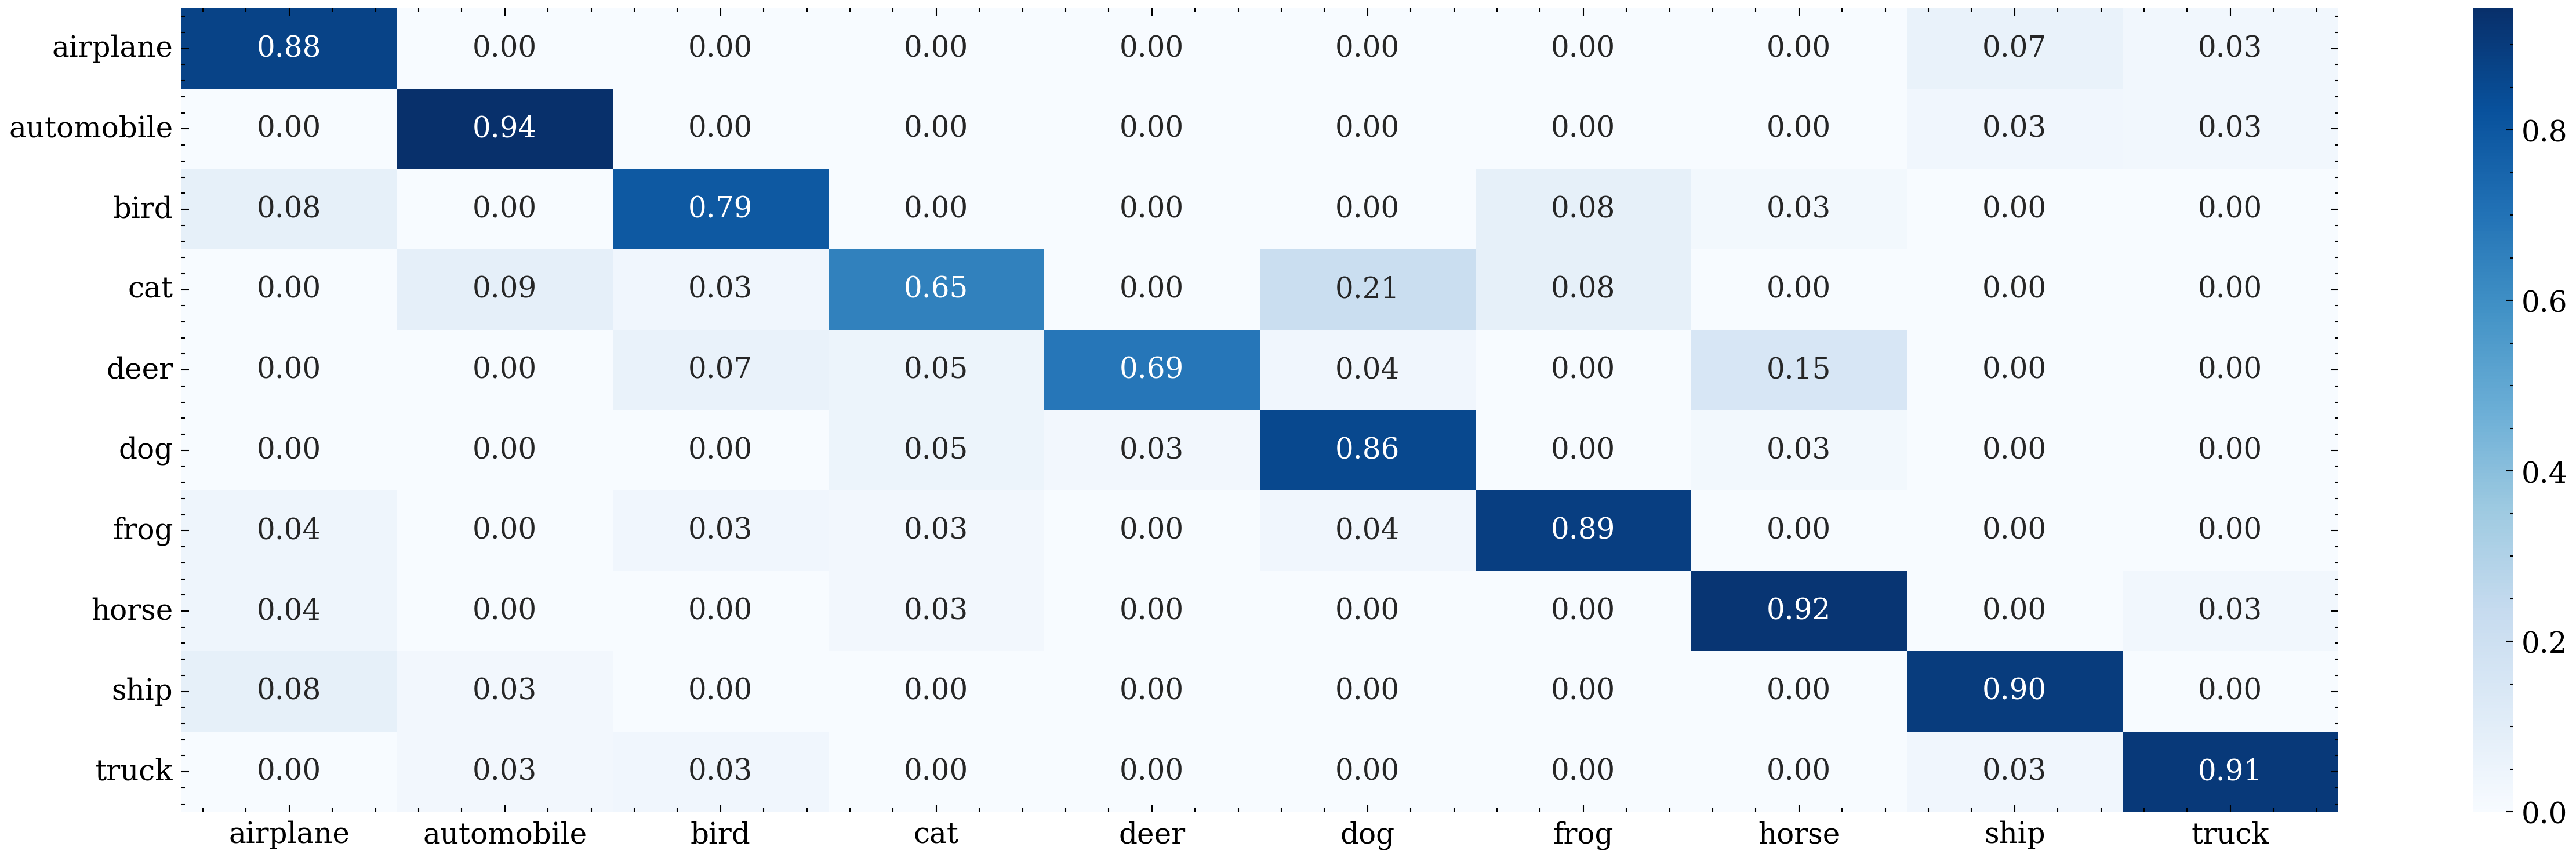

In [23]:
# --- compute confusion matrices ---


C = confusion_matrix(all_labels, all_preds_edo)

print("\nConfusion Matrix (EDO):")
C = C.astype("float") / C.astype("float").sum(axis=1)

plt.figure(figsize = (20,6))

sns.heatmap(C, annot=True, fmt='.2f', cmap='Blues',     xticklabels=list(class_name_cif10.values()),  # add names on x-axis
    yticklabels=list(class_name_cif10.values()))   # add names on y-axis)

In [24]:
print(feats[0].shape), len(all_labels)


(24, 1, 768)


(None, 325)

In [25]:
trajectories = torch.from_numpy(feats[0]).permute(1, 0, 2) #torch.stack(feats[0], dim=0)[:, :, 0].squeeze(2)
print(trajectories.shape)

torch.Size([1, 24, 768])


In [26]:
teacher_trajectories = hidden_states[:, :, 0].permute(1, 0, 2)
teacher_trajectories.shape

torch.Size([1, 12, 768])

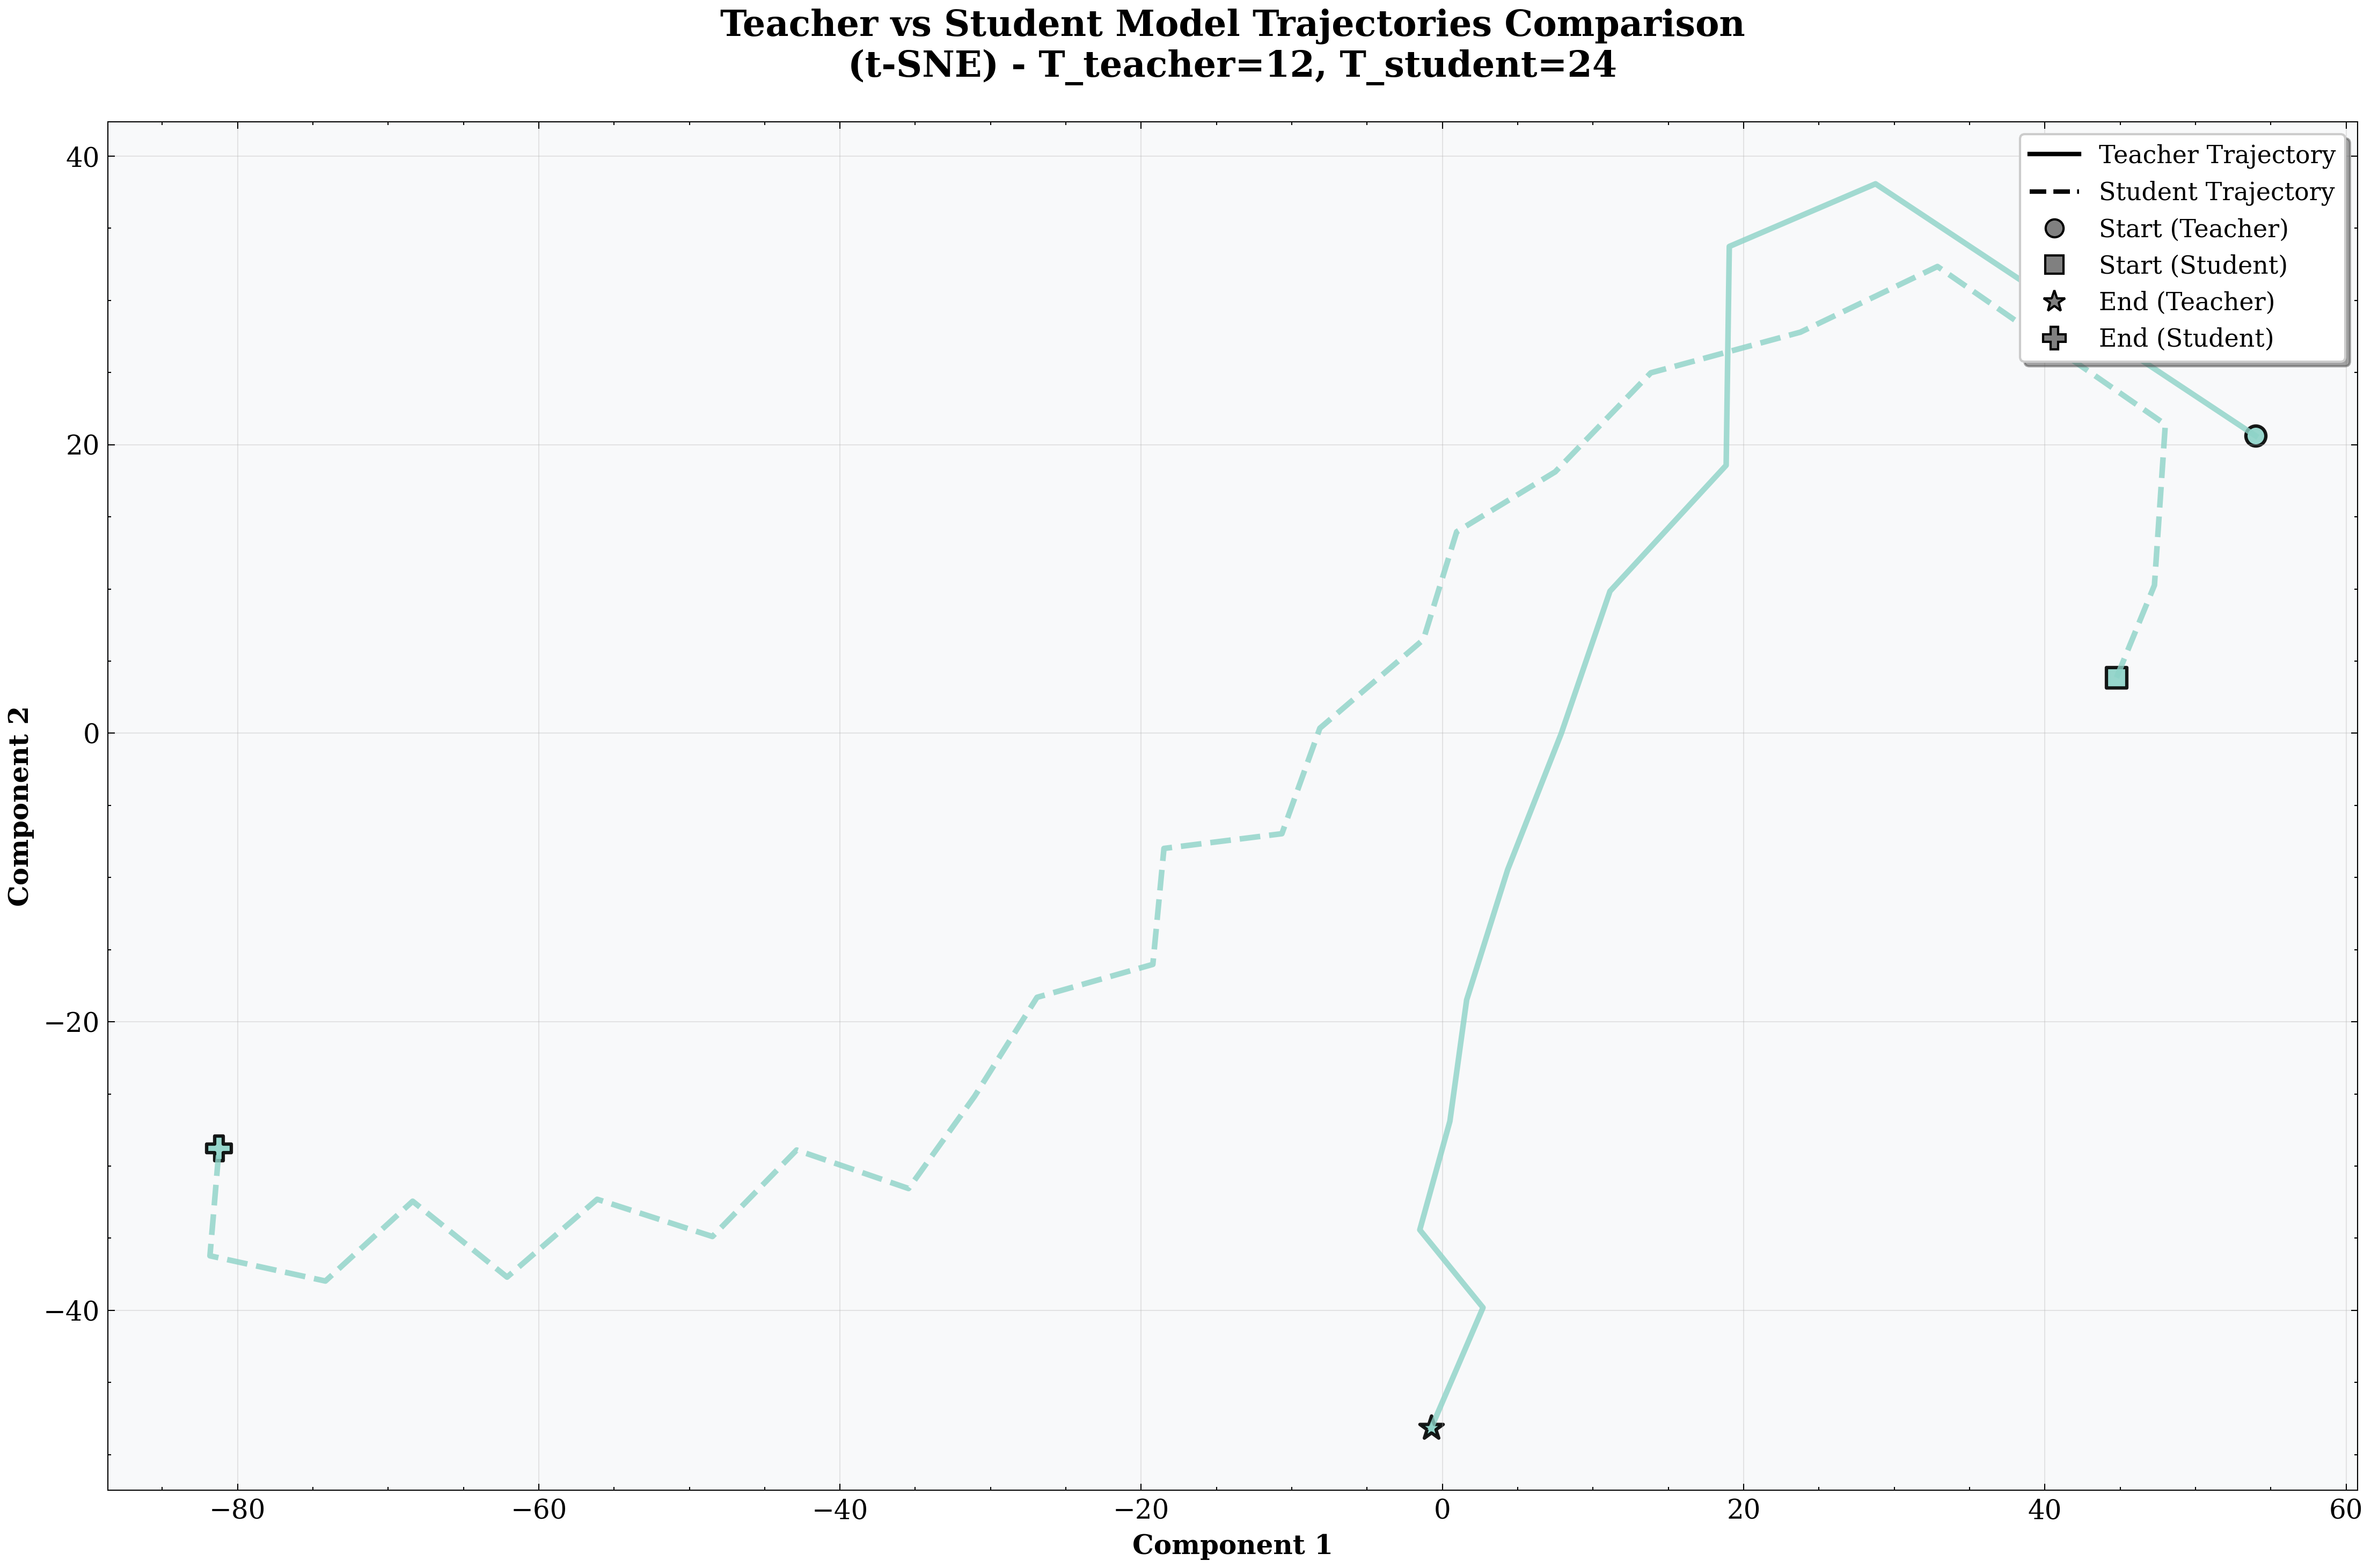

In [27]:
fig1 = plot_trajectories_comparison(teacher_trajectories[:, :, :], trajectories[:, :, :], reduction_method="tsne")


In [28]:
print(np.concatenate(feats, 1).shape)

(24, 325, 768)


In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_class_centroids(
    trajectories,
    labels,
    class_name,
    reduction_method='pca',
    figsize=(12, 9),
    annotate=True
):
    """
    Plot the 2D distribution of the last trajectory points per sample,
    with class centroids labeled by their class names.

    Args:
        trajectories: torch.Tensor [B, T, D] - full trajectories
        labels: torch.Tensor or np.ndarray [B] - class indices for each sample
        class_name: dict {int: str} - maps class indices to names
        reduction_method: str - 'pca' or 'tsne'
        figsize: tuple - figure size
        annotate: bool - whether to show class labels on centroids
    """
    # Convert to numpy
    traj_np = trajectories.detach().cpu().numpy()
    labels_np = np.array(labels)
    B, T, D = traj_np.shape

    # Take last points
    last_points = traj_np[:, -1, :]  # [B, D]

    # Compute class centroids
    unique_labels = np.unique(labels_np)
    centroids = np.stack([
        last_points[labels_np == c].mean(axis=0)
        for c in unique_labels
    ])

    # Reduce to 2D
    if reduction_method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        reduced_points = reducer.fit_transform(last_points)
        reduced_centroids = reducer.transform(centroids)
        title_suffix = f"PCA (explained variance: {reducer.explained_variance_ratio_.sum():.2f})"
    elif reduction_method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)#min(30, B//4))
        reduced_points = reducer.fit_transform(last_points)
        # Compute 2D centroid as mean of reduced samples per class
        reduced_centroids = np.stack([
            reduced_points[labels_np == c].mean(axis=0)
            for c in unique_labels
        ])
        title_suffix = "t-SNE"
    else:
        raise ValueError("reduction_method must be 'pca' or 'tsne'")

    # Plot
    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        reduced_points[:, 0],
        reduced_points[:, 1],
        c=labels_np,
        cmap='tab20',
        alpha=0.7,
        s=40,
        edgecolor='k',
        linewidth=0.3
    )

    plt.scatter(
        reduced_centroids[:, 0],
        reduced_centroids[:, 1],
        c='black',
        s=100,
        marker='X',
        label='Class Centroid'
    )

    # Annotate centroids with class labels
    if annotate:
        for i, c in enumerate(unique_labels):
            plt.text(
                reduced_centroids[i, 0],
                reduced_centroids[i, 1],
                class_name.get(int(c), str(c)),
                fontsize=9,
                fontweight='bold',
                ha='center',
                va='center',
                color='white',
                bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.2')
            )

    plt.title(f"Class-Guided Embedding Clusters ({title_suffix})", fontsize=15, fontweight='bold')
    plt.xlabel("Component 1", fontsize=12, fontweight='bold')
    plt.ylabel("Component 2", fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


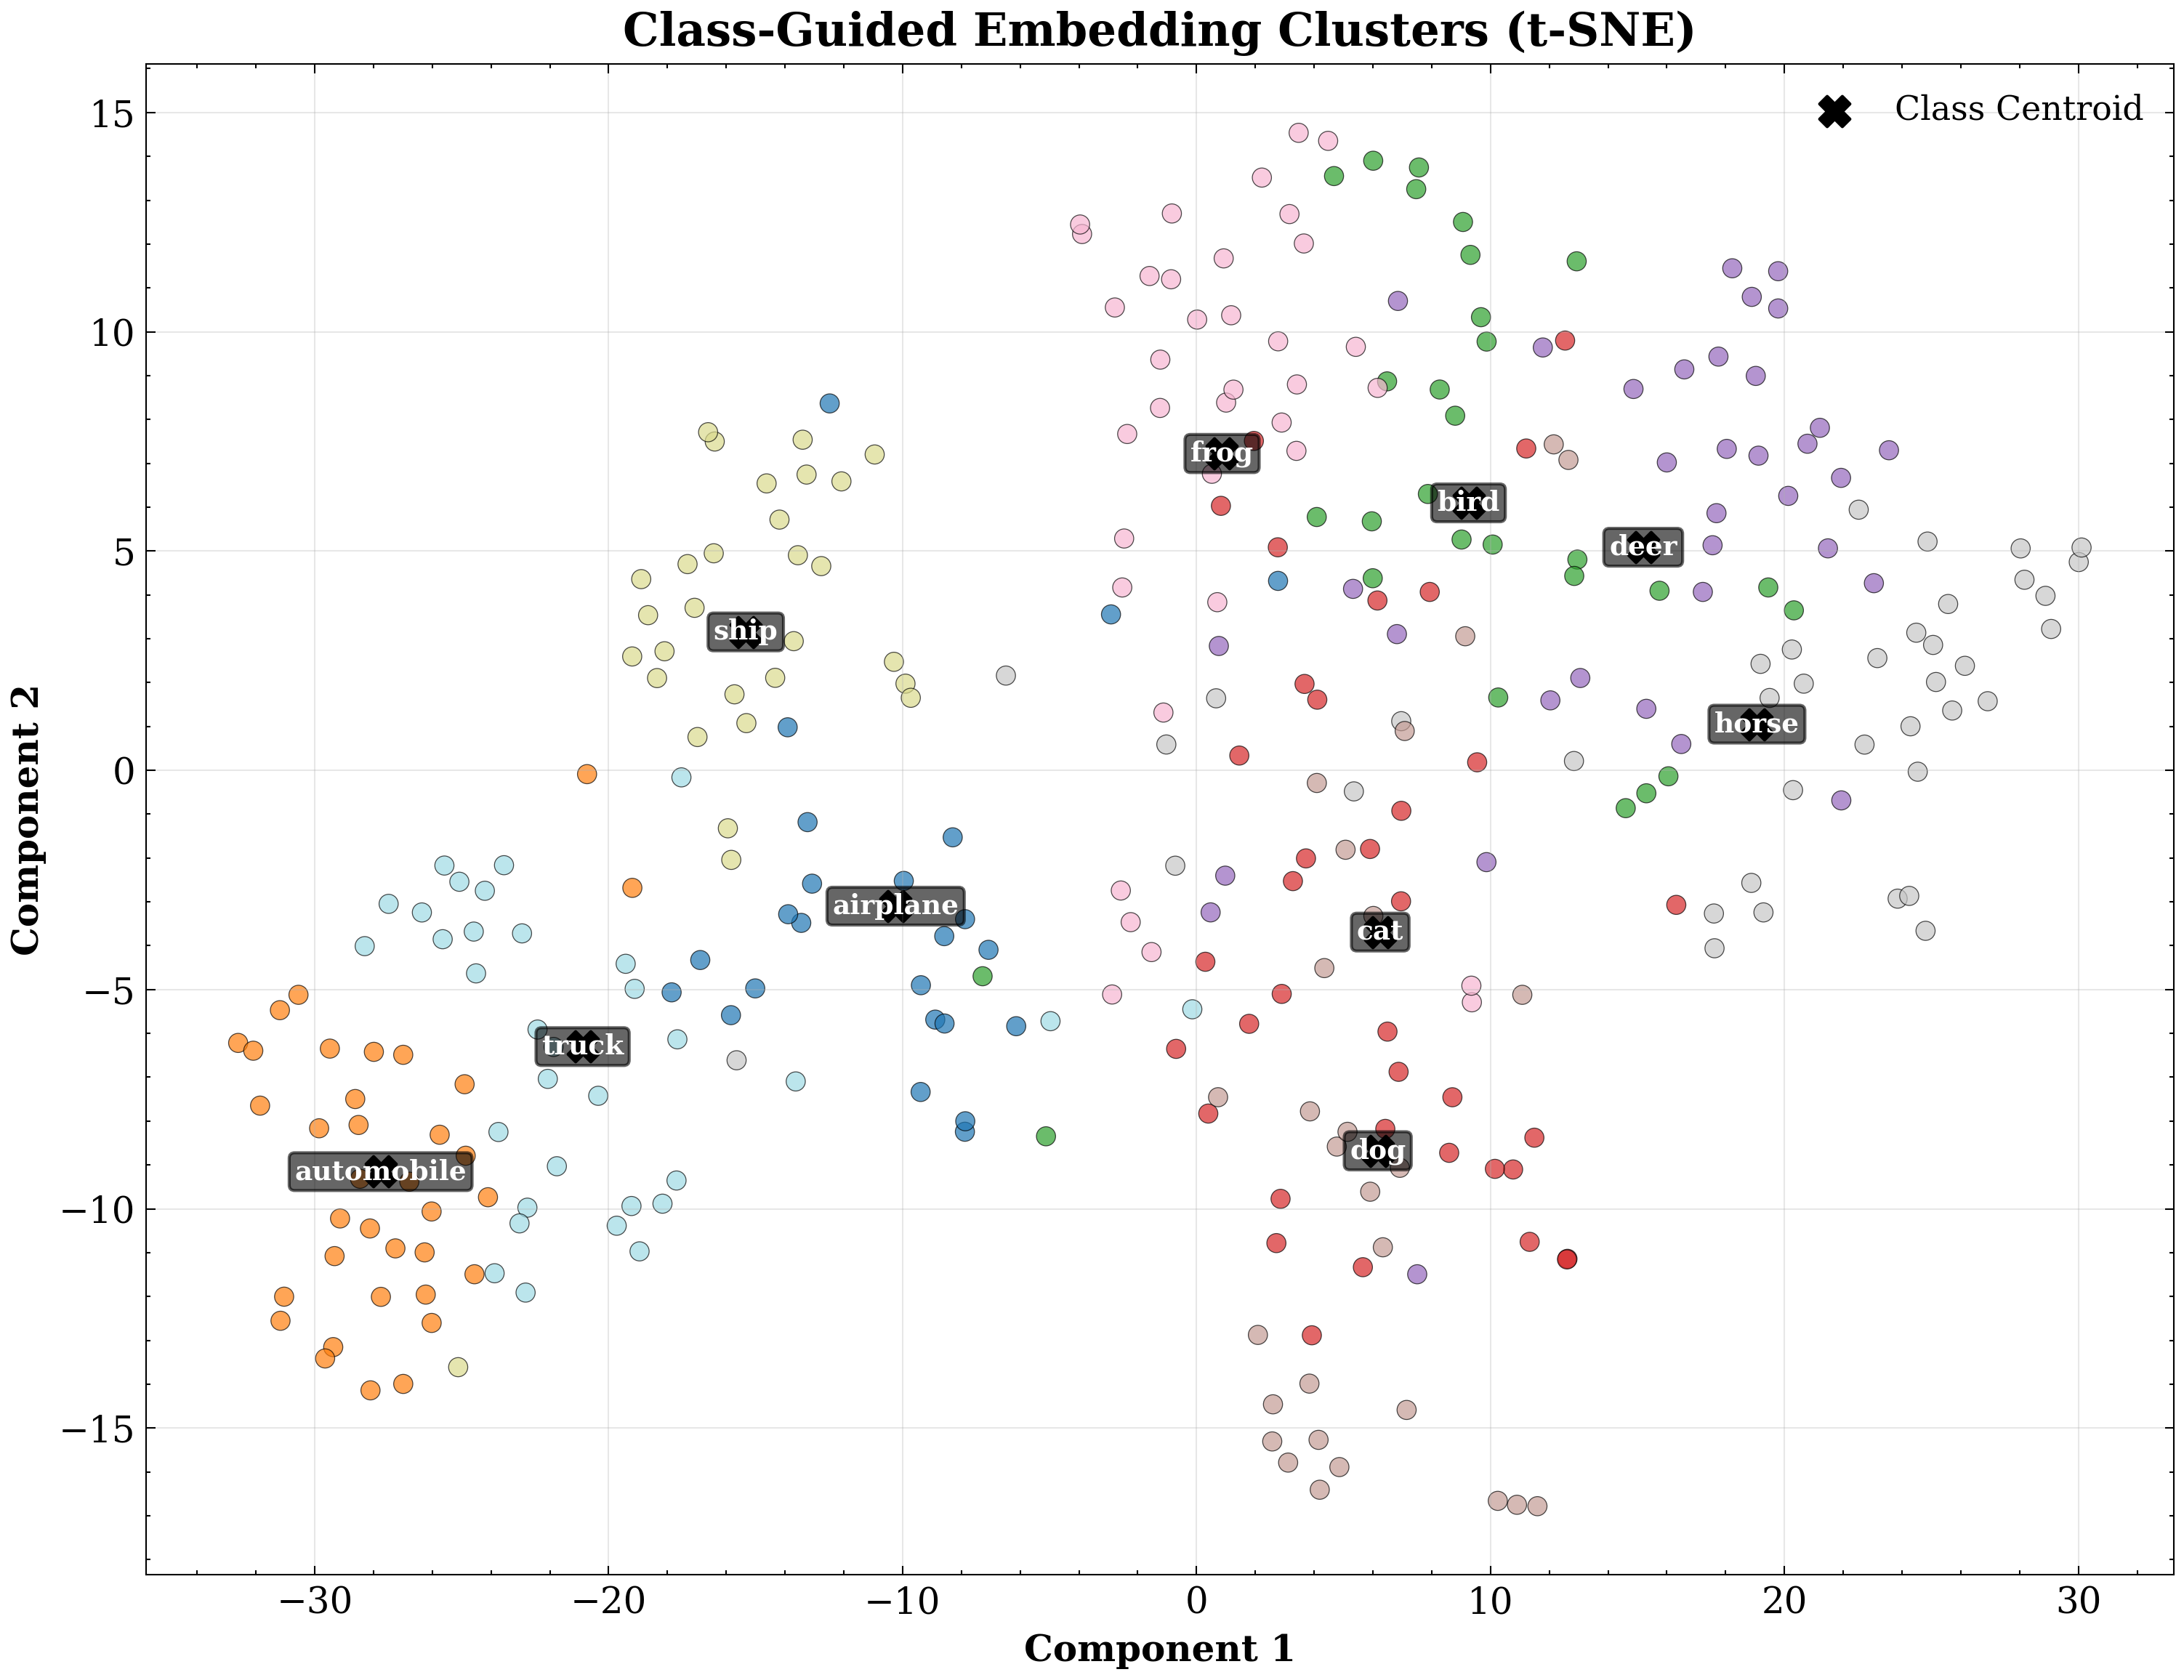

In [30]:
points = torch.from_numpy(np.concatenate(feats, 1)).permute(1, 0, 2) #torch.stack(feats[0], dim=0)[:, :, 0].squeeze(2)

fig1 = plot_class_centroids(points, labels=all_labels, class_name=class_name_cif10, reduction_method="tsne")


## Representation VIT Trained

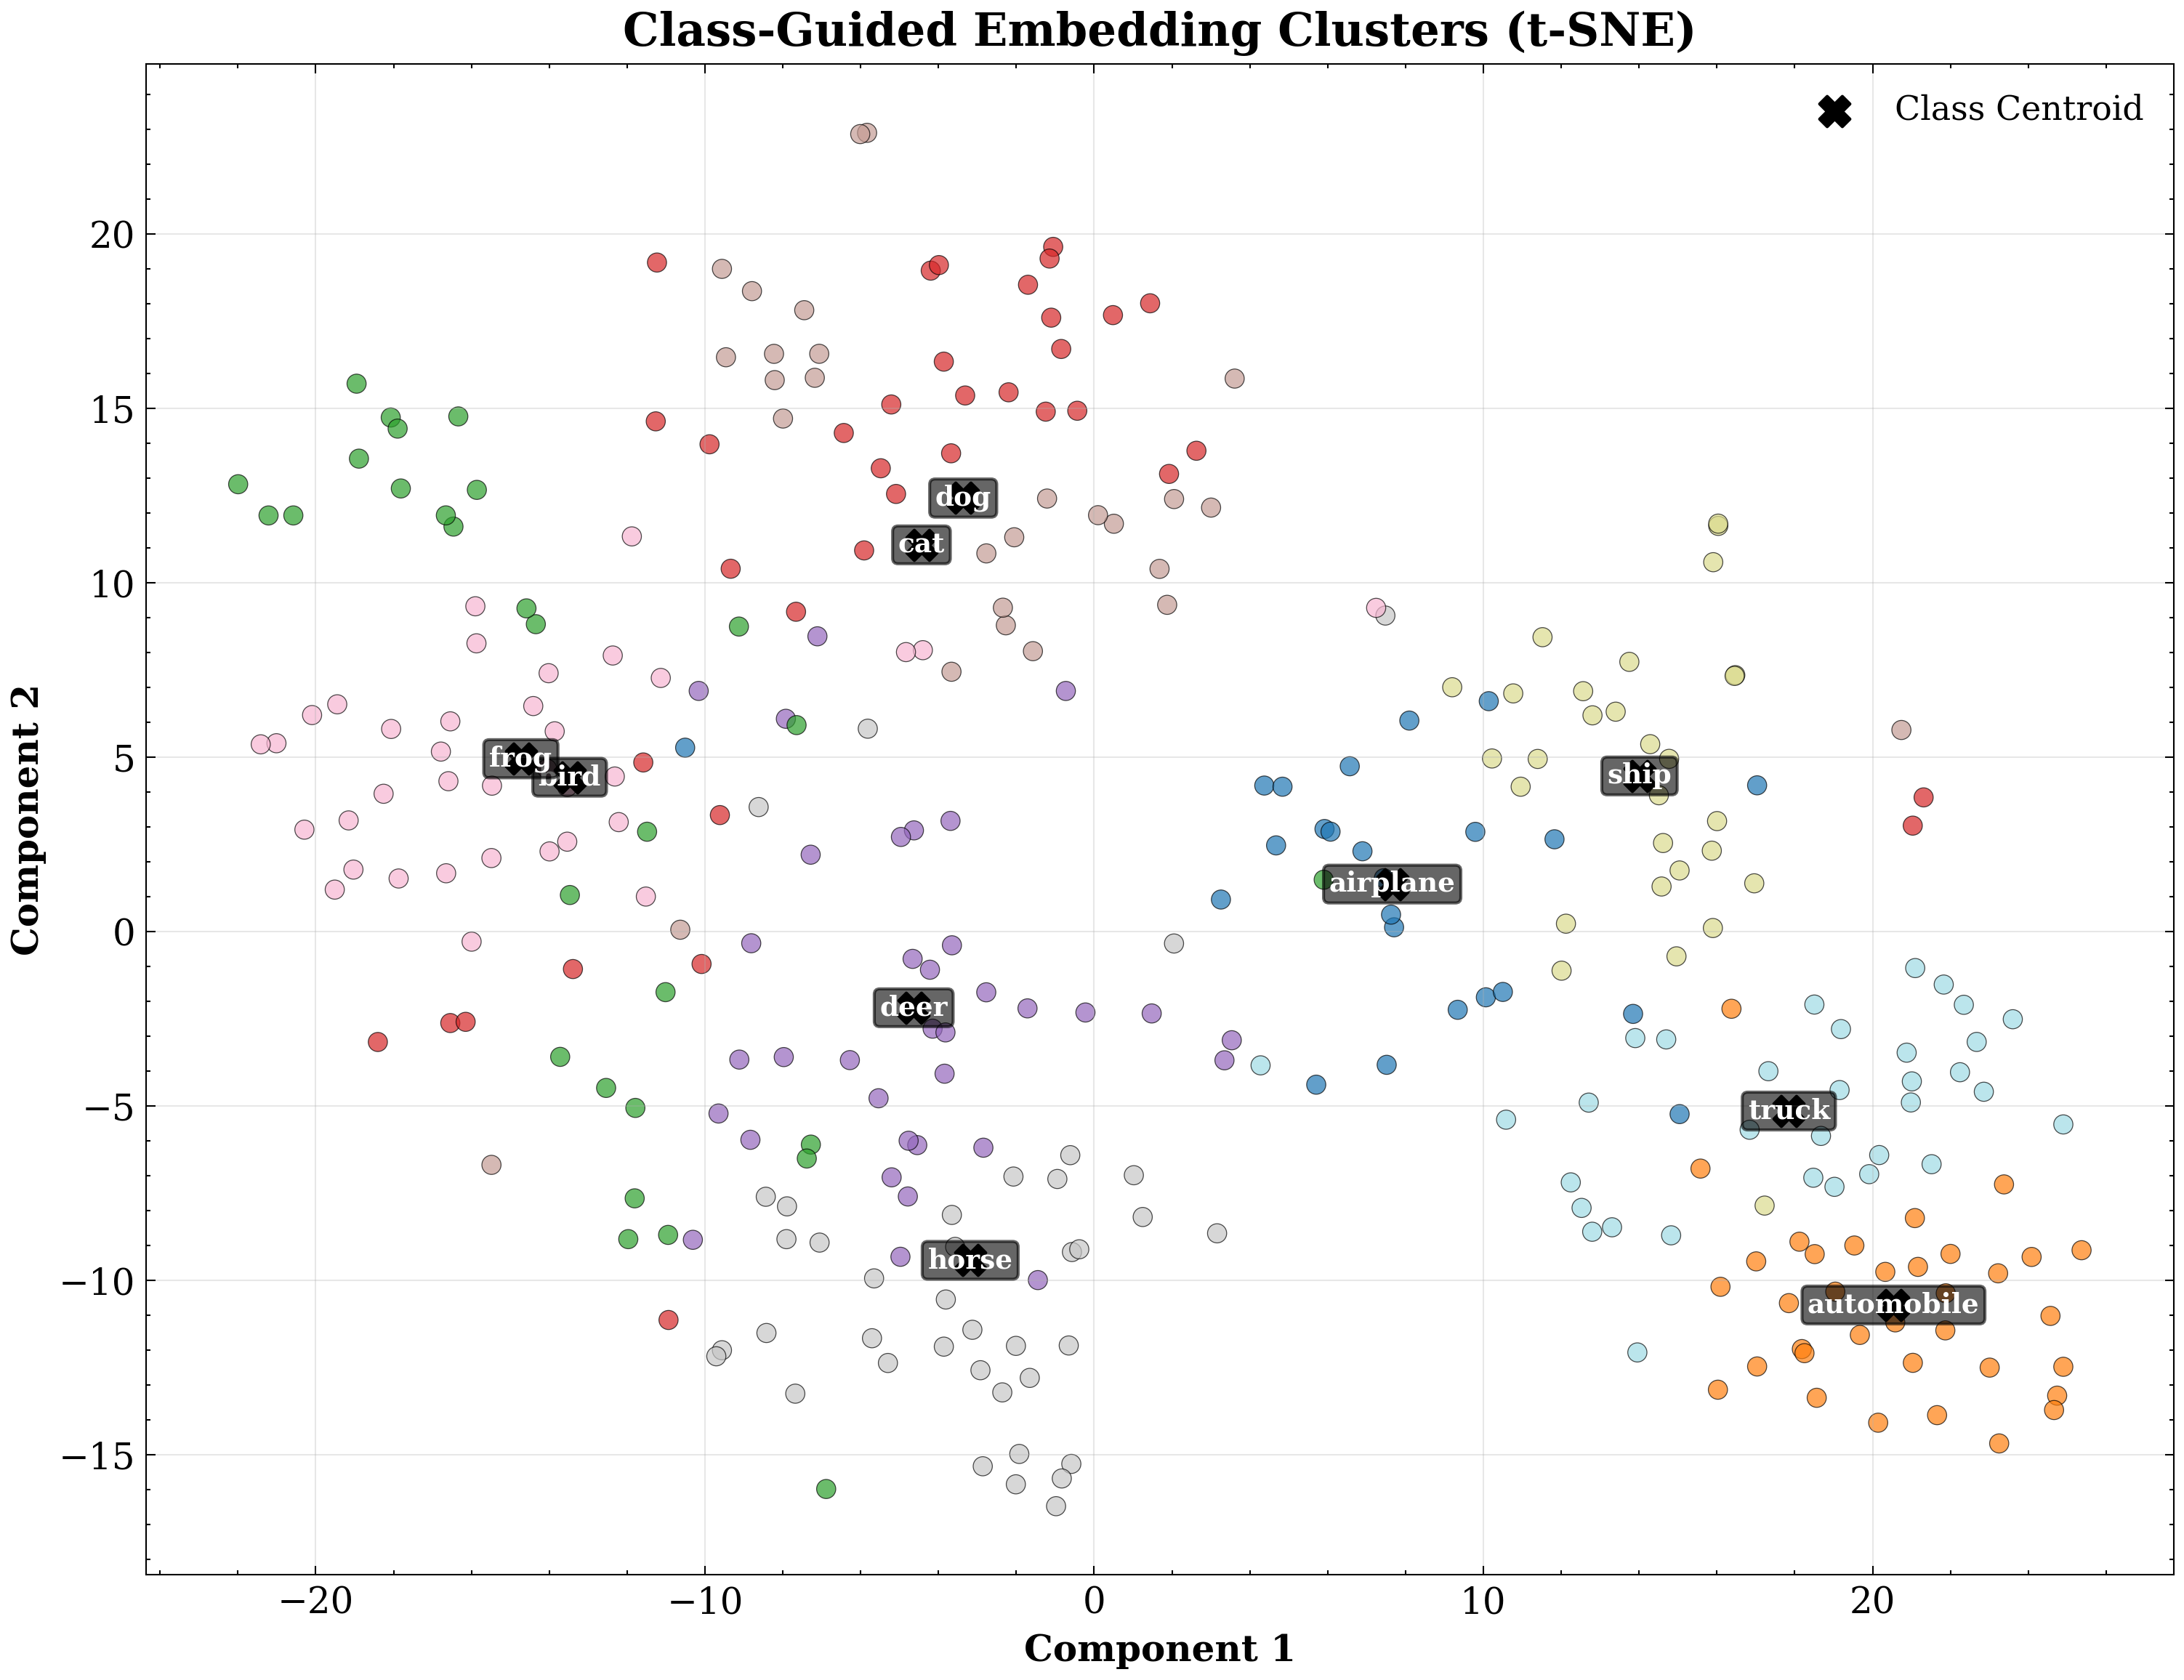

In [32]:
points = torch.from_numpy(np.concatenate(feats_teacher, 1)).permute(1, 0, 2) #torch.stack(feats[0], dim=0)[:, :, 0].squeeze(2)

fig1 = plot_class_centroids(points, labels=all_labels, class_name=class_name_cif10, reduction_method="tsne")

## Representation DINO 1

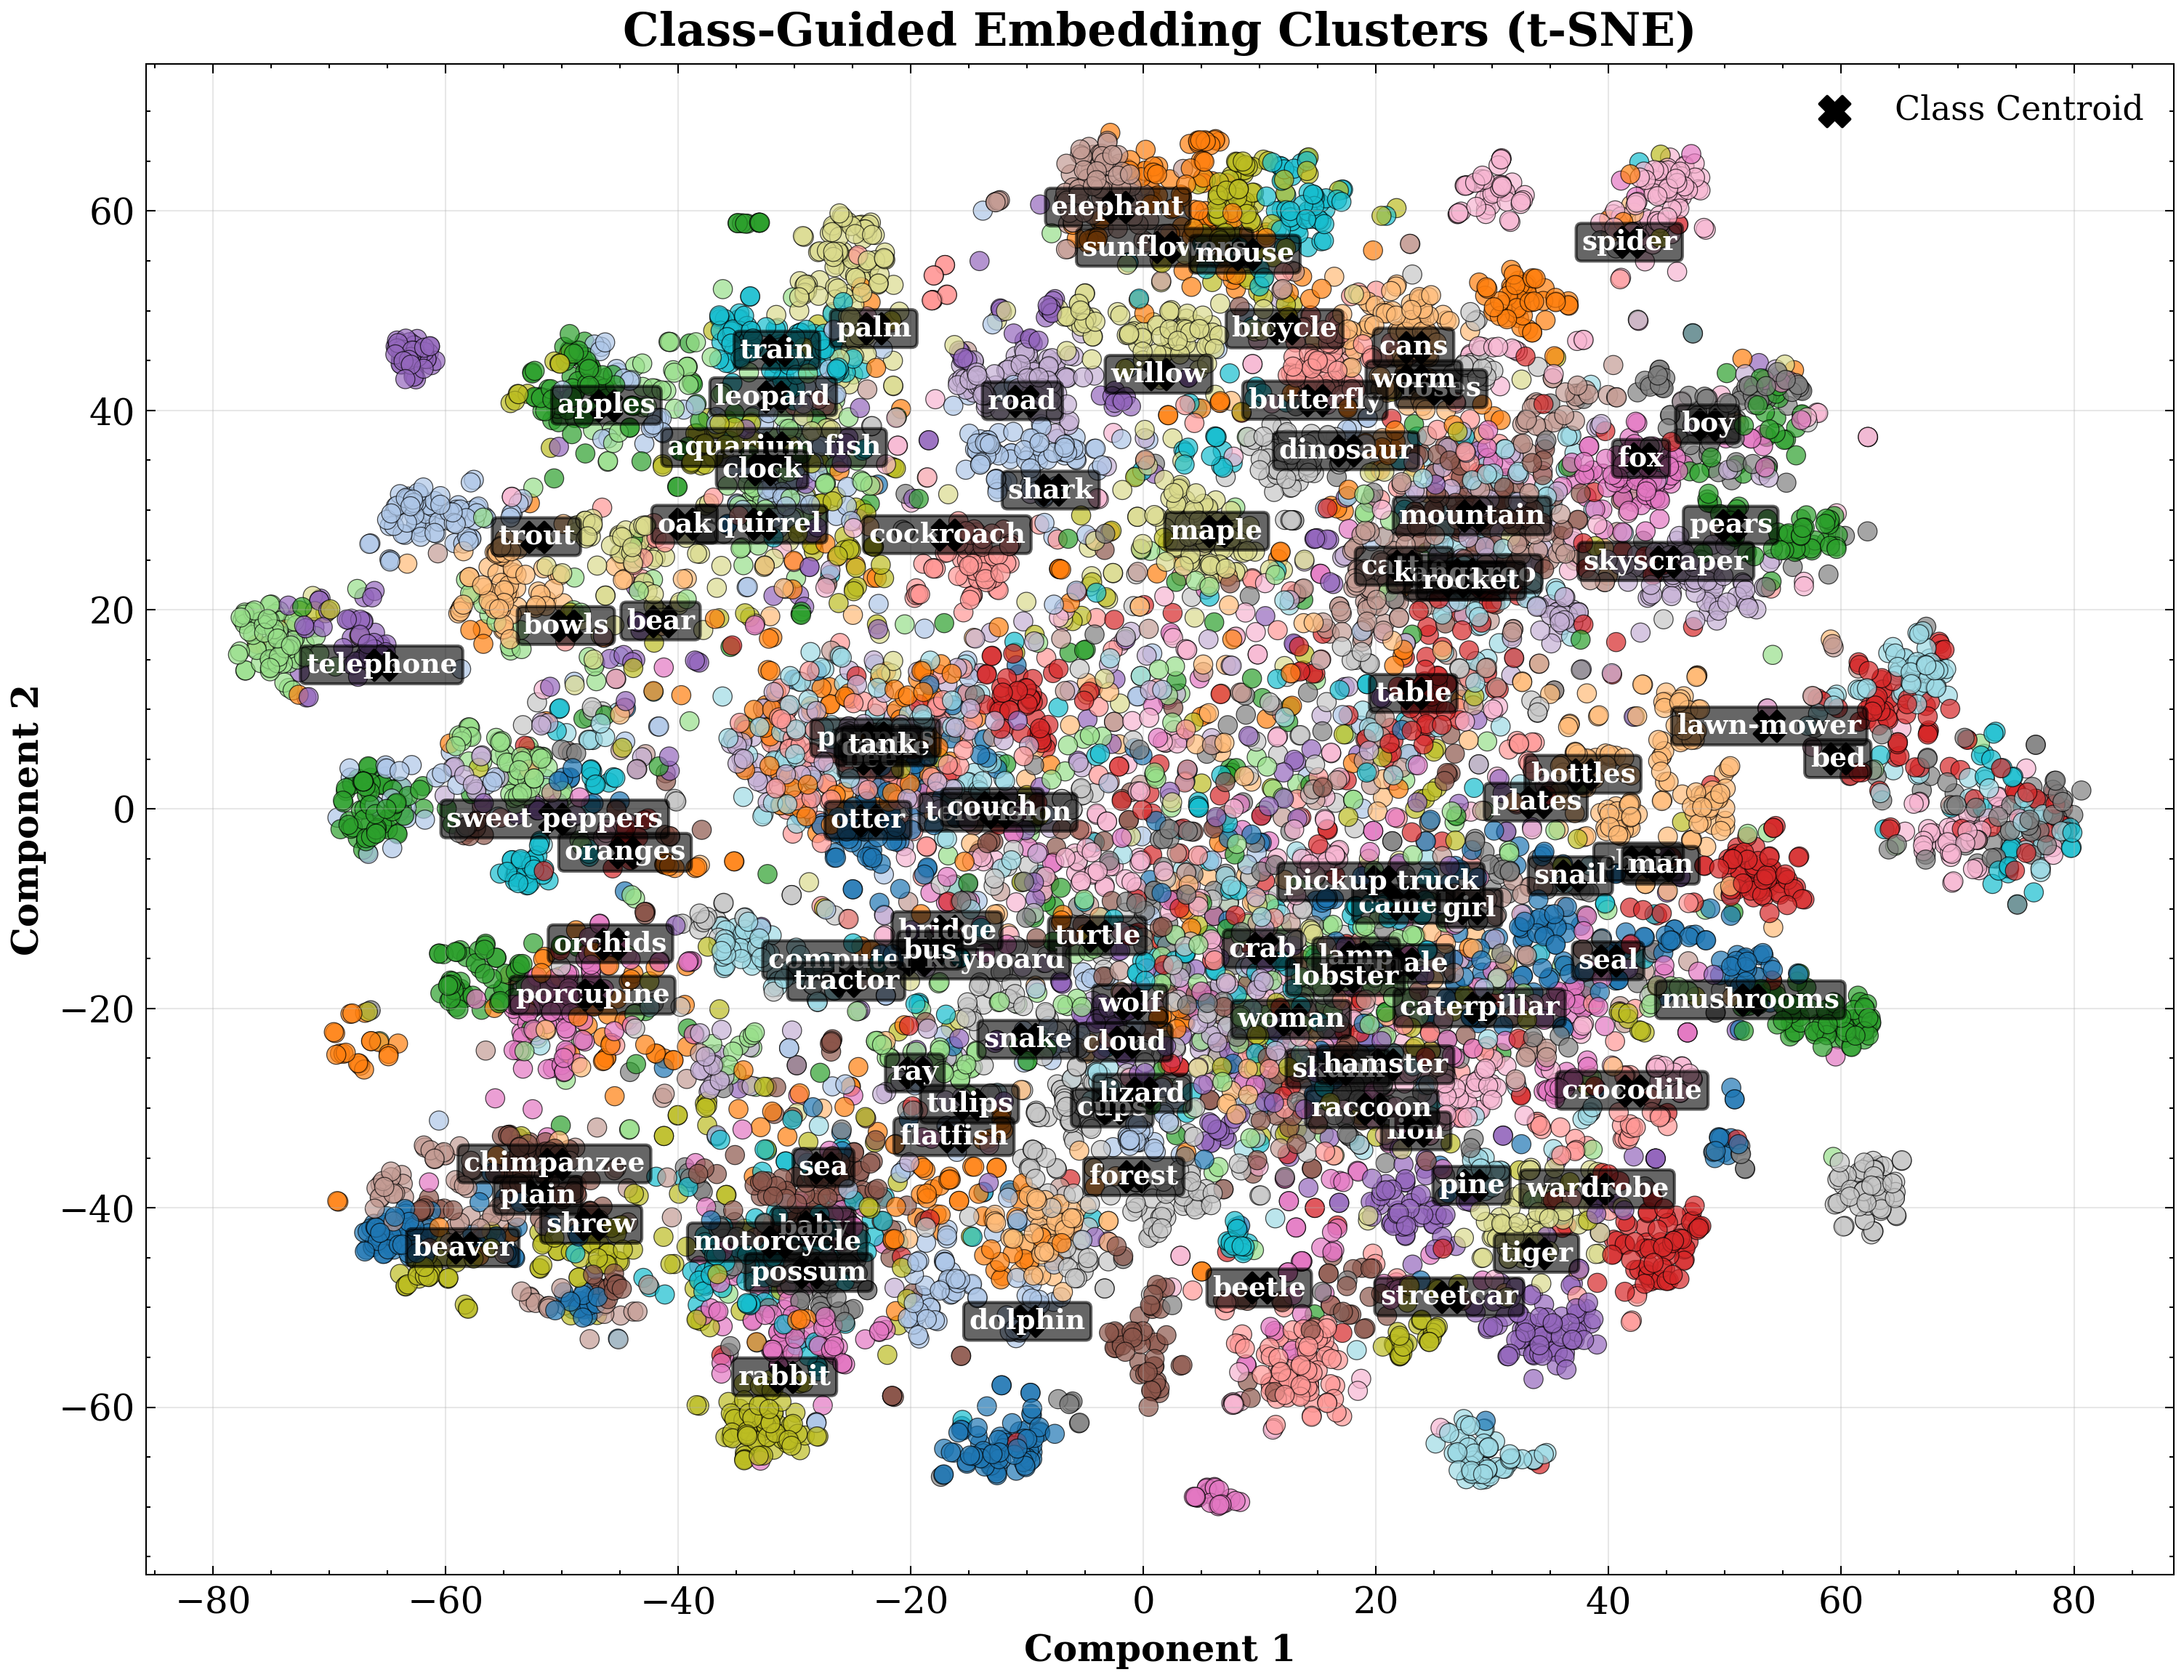

In [ ]:
points = torch.from_numpy(np.concatenate(feats_teacher, 1)).permute(1, 0, 2) #torch.stack(feats[0], dim=0)[:, :, 0].squeeze(2)

fig1 = plot_class_centroids(points, labels=all_labels, class_name=class_name_cif10, reduction_method="tsne")